In [7]:
from py_vollib_vectorized import vectorized_black_scholes_merton,get_all_greeks
import numpy as np
import plotly as py
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from monte_carlo.monte_carlo_class1 import MonteCarloOptionPricing
import matplotlib.pylab as plt

%matplotlib inline
init_notebook_mode(connected = True)

In [25]:
# 假设持有一日历价差多头
gamma_1 = []
gamma_2 = []

for i in np.arange(10000,70000,1000):
    gamma_1.append((get_all_greeks('c',int(i),40000,0.25,0,0.3)['gamma'])[0])
    gamma_2.append((get_all_greeks('c',int(i),40000,0.5,0,0.3)['gamma'])[0])

trace = go.Scatter(x=np.arange(30000,50000,100),
                   y=gamma_1,
                   mode='lines',
                   name='gamma_近月')
trace1 = go.Scatter(x=np.arange(30000,50000,100),
                   y=gamma_2,
                   mode='lines',
                   name='gamma_远月')
trace2 = go.Scatter(x=np.arange(30000,50000,100),
                   y=np.array(gamma_2) - np.array(gamma_1),
                   mode='lines',
                   name='calender_gamma')
data = [trace,trace1,trace2]
py.offline.iplot({'data':data,"layout":go.Layout(title="calender gamma")})

从上图可看出，一个日历价差多头，只有在**平值附近**时，才能保持负gamma，只要价格开始偏离，gamma就会变为正数，然后衰减至0。这主要是由于**gamma跟时间的相关性**导致的
所以gamma是需要联系**价格区间**来控制的，而且在**价格波动剧烈时**容易失效

In [9]:
S0 = 50  # e.g. spot price = 35
K = 52.08  # e.g. exercise price = 40
T = 1  # e.g. one year
r = 0.05  # e.g. risk free rate = 1%
sigma = 0.3  # e.g. volatility = 5%
div_yield = 0.0  # e.g. dividend yield = 1%
no_of_slice = 252

In [10]:
MC = MonteCarloOptionPricing(S0=S0,
                             K=K,
                             T=T,
                             r=r,
                             sigma=sigma,
                             div_yield=div_yield,
                             simulation_rounds=int(10000),
                             no_of_slices=no_of_slice,
                             # fix_random_seed=True,
                             fix_random_seed=500)

MC.stock_price_simulation()
price_array = MC.price_array

----------------------------------------------------------------
 Number of simulations 10000 
 S0 50.0 
 K 52.1 
 Maximum Stock price 153.51 
 Minimum Stock price 15.78 
 Average stock price 52.745 
 Standard Error 0.16120 
 Number of simulations 10000 
 S0 50.0 
 K 52.1 
 Maximum Strike price 50.60 
 Minimum Strike price 49.38 
 Average strike price 50.001 
 Standard Error 0.00159 
----------------------------------------------------------------


In [11]:
price = price_array[10,:] # 随意选择一条价格生成路径
hedge_pnl = []
for i in np.arange(1,no_of_slice,1):
    pnl = (0.5 * get_all_greeks('c',price[i-1],K,T,0,sigma)['gamma'][0] * (price[i] - price[i-1]) * (price[i] - price[i-1]) + get_all_greeks('c',price[i-1],K,T,0,sigma)['theta'][0])
    T -= 1/no_of_slice
    hedge_pnl.append(pnl)

In [12]:
trace = go.Scatter(x = np.arange(1,no_of_slice,1),
                   y = hedge_pnl,
                   mode = 'lines')
data = [trace]
py.offline.iplot({'data':data})

1. 每次模拟出现的结果都不一样
2. 但总体对冲pnl都在0～1附近
3. 会常常出现一个情况，越靠近到期日时，pnl会在一个时点上收敛至0，且之后不会再有波动

In [13]:
sum(np.array(hedge_pnl))

0.399371096852025

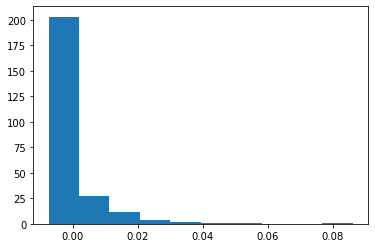

In [14]:
plt.hist(hedge_pnl)
plt.show()